# Cryptocurrency Analysis

*Author* : **Thanasis Zoumpekas**


*Codename* : **thzou**



## Import the necessary libraries to work with

In [71]:
import os
import numpy as np
import pandas as pd
import pickle
import quandl
import datetime
import statsmodels.api as sm
from scipy import stats


import time
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns; sns.set()

import sys
from PIL import Image # for logos
import io
from itertools import product
import warnings

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset

from plotly import tools
import plotly.offline as py
import plotly.graph_objs as go
import plotly.figure_factory as ff
py.init_notebook_mode(connected=True)




## Data Acquisition & Preprocessing
The data source was mainly Poloniex’s API. First of all I have downloaded Bitcoin (BTC) daily price data from Quandl from different exchanges, in order to get an average value of Bitcoin’s price. Then data of various cryptocurrencies downloaded from their release date to 2018 with a period of 86400 seconds, i.e. daily price data. The crypto-coins selected were the following XRP, ETH, XMR, STR, LTC, DGB, BTS, DOGE, BCH, BCN, ZRX, DASH, ZEC, MAID, ETC. The aforementioned coins are Bitcoins pairs in terms of trading, and I transformed their prices in USD fiat currency, using the average value of Bitcoin’s price. I have selected the above cryptocurrencies, because they are some of the mostly traded cryptocurrencies in Poloniex exchange.

Below there is a big picture of their price movement from their early life till today, in log scale for better comparison and representation.

<center> <h2>Bitcoin</h2> </center>

![](images/bitcoin.jpg)

The function below is used to download and cache datasets from Quandl.

In [72]:
def get_quandl_data(quandl_id):
    '''Download and cache Quandl dataseries'''
    cache_path = '{}.pkl'.format(quandl_id).replace('/','-')
    try:
        f = open(cache_path, 'rb')
        df = pickle.load(f)   
        print('Loaded {} from cache'.format(quandl_id))
    except (OSError, IOError) as e:
        print('Downloading {} from Quandl'.format(quandl_id))
        df = quandl.get(quandl_id, returns="pandas")
        df.to_pickle(cache_path)
        print('Cached {} at {}'.format(quandl_id, cache_path))
    return df

In [73]:
# Pull Kraken BTC price exchange data
btc_usd_price_kraken = get_quandl_data('BCHARTS/KRAKENUSD')

Loaded BCHARTS/KRAKENUSD from cache


In [74]:
btc_usd_price_kraken.head()

Open       High        Low      Close  Volume (BTC)  \
Date                                                                   
2014-01-07  874.67040  892.06753  810.00000  810.00000     15.622378   
2014-01-08  810.00000  899.84281  788.00000  824.98287     19.182756   
2014-01-09  825.56345  870.00000  807.42084  841.86934      8.158335   
2014-01-10  839.99000  857.34056  817.00000  857.33056      8.024510   
2014-01-11  858.20000  918.05471  857.16554  899.84105     18.748285   

            Volume (Currency)  Weighted Price  
Date                                           
2014-01-07       13151.472844      841.835522  
2014-01-08       16097.329584      839.156269  
2014-01-09        6784.249982      831.572913  
2014-01-10        6780.220188      844.938794  
2014-01-11       16698.566929      890.671709

In [75]:
btc_usd_price_kraken.tail()

Open    High     Low   Close  Volume (BTC)  Volume (Currency)  \
Date                                                                          
2018-09-20  6390.6  6424.0  6382.6  6392.0    481.902286       3.085268e+06   
2018-09-21     0.0     0.0     0.0     0.0      0.000000       0.000000e+00   
2018-09-22  6714.9  6744.0  6625.2  6717.0   1482.491663       9.899944e+06   
2018-09-23  6705.3  6768.0  6660.1  6700.0   1383.163063       9.274045e+06   
2018-09-24  6700.2  6719.9  6570.9  6590.8   3356.378108       2.226582e+07   

            Weighted Price  
Date                        
2018-09-20     6402.268693  
2018-09-21        0.000000  
2018-09-22     6677.908756  
2018-09-23     6704.954306  
2018-09-24     6633.881778

In [76]:
# Pull pricing data for 3 more BTC exchanges
exchanges = ['COINBASE','BITSTAMP','ITBIT']

exchange_data = {}

exchange_data['KRAKEN'] = btc_usd_price_kraken

for exchange in exchanges:
    exchange_code = 'BCHARTS/{}USD'.format(exchange)
    btc_exchange_df = get_quandl_data(exchange_code)
    exchange_data[exchange] = btc_exchange_df

Loaded BCHARTS/COINBASEUSD from cache
Loaded BCHARTS/BITSTAMPUSD from cache
Loaded BCHARTS/ITBITUSD from cache


In [77]:
def merge_dfs_on_column(dataframes, labels, col):
    '''Merge a single column of each dataframe into a new combined dataframe'''
    series_dict = {}
    for index in range(len(dataframes)):
        series_dict[labels[index]] = dataframes[index][col]
        
    return pd.DataFrame(series_dict)

In [78]:
# Merge the BTC price dataseries' into a single dataframe
btc_usd_datasets = merge_dfs_on_column(list(exchange_data.values()), list(exchange_data.keys()), 'Weighted Price')
btc_usd_datasets_close = merge_dfs_on_column(list(exchange_data.values()), list(exchange_data.keys()), 'Close')

### Data Cleaning & Aggregation

In [79]:
# Remove "0" values
btc_usd_datasets.replace(0, np.nan, inplace=True)

In [80]:
btc_usd_datasets.tail()

BITSTAMP     COINBASE        ITBIT       KRAKEN
Date                                                          
2018-09-20  6414.746140  6425.070859  6400.345052  6402.268693
2018-09-21  6672.390726  6671.021686          NaN          NaN
2018-09-22  6699.868716  6718.812830  6684.779206  6677.908756
2018-09-23  6709.320977  6701.515489  6715.201309  6704.954306
2018-09-24  6628.175577  6629.849040  6629.242849  6633.881778

In [81]:
# Calculate the average BTC price as a new column
btc_usd_datasets['avg_btc_price_usd'] = btc_usd_datasets.mean(axis=1)
btc_usd_datasets_close['close'] = btc_usd_datasets_close.mean(axis=1)

In [82]:
# Plot the average BTC price
btc_trace = go.Scatter(x=btc_usd_datasets.index, y=btc_usd_datasets['avg_btc_price_usd'])
data = [btc_trace]
layout = go.Layout(
    title='Bitcoin Average Price in USD',
    xaxis=dict(
        title='Time',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    ),
    yaxis=dict(
        title='Average Weighted Price',
        titlefont=dict(
            family='Courier New, monospace',
            size=18,
            color='#7f7f7f'
        )
    )
)
fig = go.Figure(data=data, layout=layout)
py.iplot(fig)


In [83]:
def df_scatter(df, title, seperate_y_axis=False, y_axis_label='', scale='linear', initial_hide=False):
    '''Generate a scatter plot of the entire dataframe'''
    label_arr = list(df)
    series_arr = list(map(lambda col: df[col], label_arr))
    
    layout = go.Layout(
        title=title,
        legend=dict(orientation="h"),
        xaxis=dict(type='date'),
        yaxis=dict(
            title=y_axis_label,
            showticklabels= not seperate_y_axis,
            type=scale
        )
    )
    
    y_axis_config = dict(
        overlaying='y',
        showticklabels=False,
        type=scale )
    
    visibility = 'visible'
    if initial_hide:
        visibility = 'legendonly'
        
    # Form Trace For Each Series
    trace_arr = []
    for index, series in enumerate(series_arr):
        trace = go.Scatter(
            x=series.index, 
            y=series, 
            name=label_arr[index],
            visible=visibility
        )
        
        # Add seperate axis for the series
        if seperate_y_axis:
            trace['yaxis'] = 'y{}'.format(index + 1)
            layout['yaxis{}'.format(index + 1)] = y_axis_config    
        trace_arr.append(trace)

    fig = go.Figure(data=trace_arr, layout=layout)
    py.iplot(fig)

In [84]:
# Plot the prices from each exchanger + average price for comparisons
df_scatter(btc_usd_datasets, 'Bitcoin Price (USD) By Exchange')

The above graph depicts the average bitcoin price in comparison with the 4 exchanges' price, BITSTAMP, COINBASE, ITBIT, KRAKEN.

<center> <h2> Altcoins </h2> </center>

![](images/altcoins.jpg)

Altcoins are the alternative cryptocurrencies launched after the success of Bitcoin. Generally, they project themselves as better substitutes to Bitcoin. The success of Bitcoin as the first peer-to-peer digital currency paved the way for many to follow. Many altcoins are trying to target any perceived limitations that Bitcoin has and come up with newer versions with competitive advantages. There is a great variety of altcoins.




We will need some helper functions. We will download trading data from Poloniex Digital Asset Exchange.





In [85]:
def get_json_data(json_url, cache_path):
    '''Download and cache JSON data, return as a dataframe.'''
    try:        
        f = open(cache_path, 'rb')
        df = pickle.load(f)   
        print('Loaded {} from cache'.format(json_url))
    except (OSError, IOError) as e:
        print('Downloading {}'.format(json_url))
        df = pd.read_json(json_url)
        df.to_pickle(cache_path)
        print('Cached {} at {}'.format(json_url, cache_path))
    return df


base_polo_url = 'https://poloniex.com/public?command=returnChartData&currencyPair={}&start={}&end={}&period={}'
start_date = datetime.datetime.strptime('2014-01-01', '%Y-%m-%d') # get data from the start of 2014
end_date = datetime.datetime.now() # up until today
pediod = 86400 # pull daily data (86,400 seconds per day)

def get_crypto_data(poloniex_pair):
    '''Retrieve cryptocurrency data from poloniex'''
    json_url = base_polo_url.format(poloniex_pair, start_date.timestamp(), end_date.timestamp(), pediod)
    data_df = get_json_data(json_url, poloniex_pair)
    data_df = data_df.set_index('date')
    return data_df


Downloading data for Bitcoin Cash, BitShares, DigiByte, Dogecoin, Ethereum, Monero, Litecoin, Ripple, Ethereum Classic, Bytecoin, 0x, Stellar, Zcach, Dash, Siacoin, Monero, and MaidSafeCoin.

In [86]:

altcoins = ['XRP','ETH','XMR','STR','LTC','DGB','BTS','DOGE','BCH','BCN','ZRX','DASH','ZEC','MAID','ETC']

altcoin_data = {}
for altcoin in altcoins:
    coinpair = 'BTC_{}'.format(altcoin)
    crypto_price_df = get_crypto_data(coinpair)
    altcoin_data[altcoin] = crypto_price_df


Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_XRP&start=1388527200.0&end=1537956867.37505&period=86400 from cache
Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_ETH&start=1388527200.0&end=1537956867.37505&period=86400 from cache
Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_XMR&start=1388527200.0&end=1537956867.37505&period=86400 from cache
Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_STR&start=1388527200.0&end=1537956867.37505&period=86400 from cache
Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_LTC&start=1388527200.0&end=1537956867.37505&period=86400 from cache
Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_DGB&start=1388527200.0&end=1537956867.37505&period=86400 from cache
Loaded https://poloniex.com/public?command=returnChartData&currencyPair=BTC_BTS&start=1388527200.0&end=1537956867.37505&period=86400 fro

**Converting the prices to USD**


In [87]:
# Calculate USD Price as a new column in each altcoin dataframe
Volumes = pd.DataFrame()
for altcoin in altcoin_data.keys():
    altcoin_data[altcoin]['price_usd'] =  altcoin_data[altcoin]['weightedAverage'] * btc_usd_datasets['avg_btc_price_usd']
    altcoin_data[altcoin]['close'] =  altcoin_data[altcoin]['close'] * btc_usd_datasets_close['close']
    Volumes[altcoin] = altcoin_data[altcoin]['volume']
    

In [88]:
Volumes = Volumes.dropna()
Volumes.tail()

ZRX         BCN          STR          ETH           XRP  \
date                                                                        
2018-09-21  60.097348   58.187172  1259.847350  1925.228346  11320.012270   
2018-09-22  14.239132   27.911752   348.739544   789.497757   5402.067806   
2018-09-23  26.889837   21.990816  1976.951743   548.571850   1947.750480   
2018-09-24  82.084264  221.622312   761.865903   863.745647   2502.688614   
2018-09-25  13.738959   63.268544   459.092973   444.585667   1806.794765   

                  DOGE         ZEC        ETC        DGB       MAID  \
date                                                                  
2018-09-21  329.186942   83.468889  49.611524  96.161588  25.398139   
2018-09-22  168.049479   24.297464  38.370954  37.701567   7.076715   
2018-09-23  104.518015  115.101701  30.348727  45.409167  35.272927   
2018-09-24  182.671196  186.976857  44.265193  51.864606  10.288236   
2018-09-25  121.257279   87.029266  14.427271  11.764415   6.320860   

                   LTC         BCH        DASH        BTS         XMR  
date                                                                   
2018-09-21  233.631001  336.850911  224.014114  79.104773  275.792264  
2018-09-22   97.467854  153.657673   79.078573  50.942773  114.998939  
2018-09-23  151.931218  125.319388   84.478809  42.429848  276.997528  
2018-09-24  163.551454  144.177425  100.936842  53.199916  121.166126  
2018-09-25   53.153308   85.066151   56.401516   9.394696   72.814168

** Combining data from altcoins with bitcoin for comparisons **

In [89]:
# Merge USD price of each altcoin into single dataframe 
combined_df = merge_dfs_on_column(list(altcoin_data.values()), list(altcoin_data.keys()), 'price_usd')
# Add BTC price to the dataframe
combined_df['BTC'] = btc_usd_datasets['avg_btc_price_usd']
# Chart all of the altocoin prices
df_scatter(combined_df, 'Cryptocurrency Prices (USD)', seperate_y_axis=False, y_axis_label='Coin Value (USD)', scale='log')

This graph provides a pretty solid "big picture" view of how the exchange rates for each currency have varied over the past few years.

Note that in the above graph, we're using a logarithmic y-axis scale in order to compare all of the currencies on the same plot.

We will now use linear scale in order to see the price of Bitcoin against all.


In [90]:
# Chart all of the altocoin prices
df_scatter(combined_df, 'Cryptocurrency Prices (USD)', seperate_y_axis=False, y_axis_label='Coin Value (USD)', scale='linear')

**Bitcoin** is without any doubt the **King of Cryptocurrencies**.

## Statistical Data Analysis

#### Correlation Analysis

 Correlation analysis is a method of statistical evaluation used to study the strength of a relationship between two, numerically measured, continuous variables. This particular type of analysis is useful when a researcher wants to establish if there are possible connections between variables. It is often misunderstood that correlation analysis determines cause and effect; however, this is not the case because other variables that are not present in the research may have impacted on the results.

If correlation is found between two variables it means that when there is a systematic change in one variable, there is also a systematic change in the other; the variables alter together over a certain period of time. If there is correlation found, depending upon the numerical values measured, this can be either positive or negative. 

    Positive correlation exists if one variable increases simultaneously with the other, i.e. the high numerical values of one variable relate to the high numerical values of the other.

    Negative correlation exists if one variable decreases when the other increases, i.e. the high numerical values of one variable relate to the low numerical values of the other.

Pearson’s product-moment coefficient is the measurement of correlation and ranges (depending on the correlation) between +1 and -1. +1 indicates the strongest positive correlation possible, and -1 indicates the strongest negative correlation possible. Therefore the closer the coefficient to either of these numbers the stronger the correlation of the data it represents. On this scale 0 indicates no correlation, hence values closer to zero highlight weaker/poorer correlation than those closer to +1/-1. 


**In our Case : **

Coefficients close to 1 or -1 mean that the series' are strongly correlated or inversely correlated respectively, and coefficients close to zero mean that the values are not correlated, and fluctuate independently of each other.

In [91]:
# split dataset to 4 datasets by year (2015,2016,2017,2018)
combined_df2018 = combined_df[combined_df.index.year == 2018]
combined_df2017 = combined_df[combined_df.index.year == 2017]
combined_df2016 = combined_df[combined_df.index.year == 2016]
combined_df2015 = combined_df[combined_df.index.year == 2015]

In [92]:
# Calculate the pearson correlation coefficients for cryptocurrencies in 2015
combined_df2015.pct_change().corr(method='pearson')

BCH       BCN       BTS      DASH       DGB      DOGE  ETC       ETH  \
BCH   NaN       NaN       NaN       NaN       NaN       NaN  NaN       NaN   
BCN   NaN  1.000000  0.074056  0.079742 -0.063124  0.083727  NaN  0.020379   
BTS   NaN  0.074056  1.000000  0.180914 -0.041574  0.451236  NaN  0.211338   
DASH  NaN  0.079742  0.180914  1.000000  0.021909  0.343590  NaN  0.077725   
DGB   NaN -0.063124 -0.041574  0.021909  1.000000  0.115053  NaN  0.040458   
DOGE  NaN  0.083727  0.451236  0.343590  0.115053  1.000000  NaN  0.144756   
ETC   NaN       NaN       NaN       NaN       NaN       NaN  NaN       NaN   
ETH   NaN  0.020379  0.211338  0.077725  0.040458  0.144756  NaN  1.000000   
LTC   NaN  0.080600  0.292658  0.233996  0.123556  0.458766  NaN  0.125556   
MAID  NaN -0.012092  0.218012  0.214884  0.100982  0.205631  NaN  0.159293   
STR   NaN  0.134637  0.372823  0.254583  0.013758  0.429419  NaN -0.022020   
XMR   NaN  0.151213  0.166790  0.221629  0.075679  0.235060  NaN  0.012600   
XRP   NaN  0.129064  0.290032  0.198138  0.000946  0.326096  NaN -0.025099   
ZEC   NaN       NaN       NaN       NaN       NaN       NaN  NaN       NaN   
ZRX   NaN       NaN       NaN       NaN       NaN       NaN  NaN       NaN   
BTC   NaN  0.150424  0.259930  0.467823  0.163470  0.530833  NaN  0.106961   

           LTC      MAID       STR       XMR       XRP  ZEC  ZRX       BTC  
BCH        NaN       NaN       NaN       NaN       NaN  NaN  NaN       NaN  
BCN   0.080600 -0.012092  0.134637  0.151213  0.129064  NaN  NaN  0.150424  
BTS   0.292658  0.218012  0.372823  0.166790  0.290032  NaN  NaN  0.259930  
DASH  0.233996  0.214884  0.254583  0.221629  0.198138  NaN  NaN  0.467823  
DGB   0.123556  0.100982  0.013758  0.075679  0.000946  NaN  NaN  0.163470  
DOGE  0.458766  0.205631  0.429419  0.235060  0.326096  NaN  NaN  0.530833  
ETC        NaN       NaN       NaN       NaN       NaN  NaN  NaN       NaN  
ETH   0.125556  0.159293 -0.022020  0.012600 -0.025099  NaN  NaN  0.106961  
LTC   1.000000  0.167850  0.237944  0.283955  0.194178  NaN  NaN  0.555553  
MAID  0.167850  1.000000  0.249684  0.219678  0.174231  NaN  NaN  0.337128  
STR   0.237944  0.249684  1.000000  0.239343  0.460662  NaN  NaN  0.391926  
XMR   0.283955  0.219678  0.239343  1.000000  0.105446  NaN  NaN  0.501417  
XRP   0.194178  0.174231  0.460662  0.105446  1.000000  NaN  NaN  0.263449  
ZEC        NaN       NaN       NaN       NaN       NaN  NaN  NaN       NaN  
ZRX        NaN       NaN       NaN       NaN       NaN  NaN  NaN       NaN  
BTC   0.555553  0.337128  0.391926  0.501417  0.263449  NaN  NaN  1.000000

In [93]:
# Calculate the pearson correlation coefficients for cryptocurrencies in 2016
combined_df2016.pct_change().corr(method='pearson')

BCH       BCN       BTS      DASH       DGB      DOGE       ETC  \
BCH   NaN       NaN       NaN       NaN       NaN       NaN       NaN   
BCN   NaN  1.000000  0.164404  0.052387  0.028774  0.110377  0.164895   
BTS   NaN  0.164404  1.000000  0.174618  0.182828  0.255691 -0.141281   
DASH  NaN  0.052387  0.174618  1.000000  0.056766  0.096036  0.003992   
DGB   NaN  0.028774  0.182828  0.056766  1.000000  0.115548 -0.063697   
DOGE  NaN  0.110377  0.255691  0.096036  0.115548  1.000000 -0.100135   
ETC   NaN  0.164895 -0.141281  0.003992 -0.063697 -0.100135  1.000000   
ETH   NaN -0.014641  0.220698  0.122695  0.096597  0.057411 -0.181991   
LTC   NaN  0.104032  0.093173 -0.012194  0.041671  0.236127 -0.131079   
MAID  NaN  0.006163  0.223003  0.119302  0.000896  0.118453 -0.121884   
STR   NaN  0.062290  0.219824  0.058083  0.114517  0.137592 -0.102654   
XMR   NaN  0.007589  0.134400  0.121537  0.046283  0.027546 -0.105898   
XRP   NaN  0.030955  0.196682  0.088657  0.151786  0.247005 -0.054095   
ZEC   NaN  0.046319  0.056437  0.040876 -0.005865 -0.002818  0.062003   
ZRX   NaN       NaN       NaN       NaN       NaN       NaN       NaN   
BTC   NaN  0.164415  0.087317 -0.014040  0.064952  0.198461 -0.170538   

           ETH       LTC      MAID       STR       XMR       XRP       ZEC  \
BCH        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
BCN  -0.014641  0.104032  0.006163  0.062290  0.007589  0.030955  0.046319   
BTS   0.220698  0.093173  0.223003  0.219824  0.134400  0.196682  0.056437   
DASH  0.122695 -0.012194  0.119302  0.058083  0.121537  0.088657  0.040876   
DGB   0.096597  0.041671  0.000896  0.114517  0.046283  0.151786 -0.005865   
DOGE  0.057411  0.236127  0.118453  0.137592  0.027546  0.247005 -0.002818   
ETC  -0.181991 -0.131079 -0.121884 -0.102654 -0.105898 -0.054095  0.062003   
ETH   1.000000 -0.064652  0.357217  0.035093  0.087216  0.085630  0.112247   
LTC  -0.064652  1.000000 -0.000378  0.113523  0.129475  0.053712  0.142880   
MAID  0.357217 -0.000378  1.000000  0.113534  0.216256  0.074009 -0.050513   
STR   0.035093  0.113523  0.113534  1.000000  0.027998  0.320116 -0.001715   
XMR   0.087216  0.129475  0.216256  0.027998  1.000000  0.027649  0.106825   
XRP   0.085630  0.053712  0.074009  0.320116  0.027649  1.000000 -0.101774   
ZEC   0.112247  0.142880 -0.050513 -0.001715  0.106825 -0.101774  1.000000   
ZRX        NaN       NaN       NaN       NaN       NaN       NaN       NaN   
BTC  -0.006502  0.750174  0.056711  0.079075  0.127520  0.044161  0.199881   

      ZRX       BTC  
BCH   NaN       NaN  
BCN   NaN  0.164415  
BTS   NaN  0.087317  
DASH  NaN -0.014040  
DGB   NaN  0.064952  
DOGE  NaN  0.198461  
ETC   NaN -0.170538  
ETH   NaN -0.006502  
LTC   NaN  0.750174  
MAID  NaN  0.056711  
STR   NaN  0.079075  
XMR   NaN  0.127520  
XRP   NaN  0.044161  
ZEC   NaN  0.199881  
ZRX   NaN       NaN  
BTC   NaN  1.000000

In [94]:
# Calculate the pearson correlation coefficients for cryptocurrencies in 2017
combined_df2017.pct_change().corr(method='pearson',)

BCH       BCN       BTS      DASH       DGB      DOGE       ETC  \
BCH   1.000000  0.085566  0.298851  0.476677  0.168491  0.183503  0.416803   
BCN   0.085566  1.000000  0.143544  0.104552  0.274616  0.250679  0.085829   
BTS   0.298851  0.143544  1.000000  0.269242  0.400368  0.545943  0.332295   
DASH  0.476677  0.104552  0.269242  1.000000  0.202279  0.317101  0.387555   
DGB   0.168491  0.274616  0.400368  0.202279  1.000000  0.478599  0.171385   
DOGE  0.183503  0.250679  0.545943  0.317101  0.478599  1.000000  0.392851   
ETC   0.416803  0.085829  0.332295  0.387555  0.171385  0.392851  1.000000   
ETH   0.300289  0.097870  0.446101  0.506911  0.258701  0.464122  0.601437   
LTC   0.233461  0.081713  0.334640  0.340153  0.161145  0.438028  0.482062   
MAID  0.273410  0.167557  0.454480  0.424599  0.412962  0.529544  0.455513   
STR   0.033214  0.158253  0.533297  0.183038  0.376090  0.512368  0.210387   
XMR   0.227677  0.120766  0.371616  0.498418  0.247405  0.444614  0.447398   
XRP   0.038085  0.084039  0.473891  0.091146  0.261302  0.408300  0.114780   
ZEC   0.288752  0.158715  0.319911  0.543080  0.222017  0.453053  0.410320   
ZRX   0.290147  0.618240  0.561719  0.413027  0.630838  0.568860  0.389660   
BTC   0.021983  0.166009  0.303198  0.307095  0.259599  0.383816  0.416562   

           ETH       LTC      MAID       STR       XMR       XRP       ZEC  \
BCH   0.300289  0.233461  0.273410  0.033214  0.227677  0.038085  0.288752   
BCN   0.097870  0.081713  0.167557  0.158253  0.120766  0.084039  0.158715   
BTS   0.446101  0.334640  0.454480  0.533297  0.371616  0.473891  0.319911   
DASH  0.506911  0.340153  0.424599  0.183038  0.498418  0.091146  0.543080   
DGB   0.258701  0.161145  0.412962  0.376090  0.247405  0.261302  0.222017   
DOGE  0.464122  0.438028  0.529544  0.512368  0.444614  0.408300  0.453053   
ETC   0.601437  0.482062  0.455513  0.210387  0.447398  0.114780  0.410320   
ETH   1.000000  0.437609  0.542973  0.259399  0.554632  0.212350  0.539700   
LTC   0.437609  1.000000  0.469323  0.307589  0.437204  0.323905  0.264172   
MAID  0.542973  0.469323  1.000000  0.396718  0.566877  0.268806  0.420849   
STR   0.259399  0.307589  0.396718  1.000000  0.327488  0.509828  0.240921   
XMR   0.554632  0.437204  0.566877  0.327488  1.000000  0.226636  0.461947   
XRP   0.212350  0.323905  0.268806  0.509828  0.226636  1.000000  0.229027   
ZEC   0.539700  0.264172  0.420849  0.240921  0.461947  0.229027  1.000000   
ZRX   0.538788  0.395516  0.642580  0.396794  0.352971  0.333469  0.595078   
BTC   0.410771  0.420645  0.432056  0.230957  0.409183  0.131469  0.291353   

           ZRX       BTC  
BCH   0.290147  0.021983  
BCN   0.618240  0.166009  
BTS   0.561719  0.303198  
DASH  0.413027  0.307095  
DGB   0.630838  0.259599  
DOGE  0.568860  0.383816  
ETC   0.389660  0.416562  
ETH   0.538788  0.410771  
LTC   0.395516  0.420645  
MAID  0.642580  0.432056  
STR   0.396794  0.230957  
XMR   0.352971  0.409183  
XRP   0.333469  0.131469  
ZEC   0.595078  0.291353  
ZRX   1.000000  0.386450  
BTC   0.386450  1.000000

In [95]:
# Calculate the pearson correlation coefficients for cryptocurrencies in 2018
combined_df2018.pct_change().corr(method='pearson')

BCH       BCN       BTS      DASH       DGB      DOGE       ETC  \
BCH   1.000000  0.490257  0.712490  0.780086  0.669074  0.612485  0.709724   
BCN   0.490257  1.000000  0.495843  0.514366  0.609298  0.627763  0.402745   
BTS   0.712490  0.495843  1.000000  0.744525  0.711409  0.674639  0.672266   
DASH  0.780086  0.514366  0.744525  1.000000  0.696230  0.706327  0.704004   
DGB   0.669074  0.609298  0.711409  0.696230  1.000000  0.689776  0.662142   
DOGE  0.612485  0.627763  0.674639  0.706327  0.689776  1.000000  0.575445   
ETC   0.709724  0.402745  0.672266  0.704004  0.662142  0.575445  1.000000   
ETH   0.802928  0.534196  0.757009  0.788993  0.760601  0.609157  0.776118   
LTC   0.779218  0.581850  0.746381  0.798555  0.730856  0.737200  0.709454   
MAID  0.700800  0.433948  0.701066  0.726147  0.692481  0.622154  0.662173   
STR   0.622713  0.416760  0.765252  0.672812  0.649573  0.626662  0.588324   
XMR   0.791428  0.497770  0.753322  0.804657  0.729565  0.661561  0.684041   
XRP   0.654743  0.427532  0.712352  0.689493  0.683245  0.595344  0.627925   
ZEC   0.731887  0.529503  0.699960  0.774006  0.659706  0.659616  0.675149   
ZRX   0.639290  0.539885  0.644941  0.666695  0.691135  0.539676  0.588677   
BTC   0.790994  0.594221  0.779703  0.786677  0.786424  0.705350  0.708527   

           ETH       LTC      MAID       STR       XMR       XRP       ZEC  \
BCH   0.802928  0.779218  0.700800  0.622713  0.791428  0.654743  0.731887   
BCN   0.534196  0.581850  0.433948  0.416760  0.497770  0.427532  0.529503   
BTS   0.757009  0.746381  0.701066  0.765252  0.753322  0.712352  0.699960   
DASH  0.788993  0.798555  0.726147  0.672812  0.804657  0.689493  0.774006   
DGB   0.760601  0.730856  0.692481  0.649573  0.729565  0.683245  0.659706   
DOGE  0.609157  0.737200  0.622154  0.626662  0.661561  0.595344  0.659616   
ETC   0.776118  0.709454  0.662173  0.588324  0.684041  0.627925  0.675149   
ETH   1.000000  0.800171  0.740259  0.655061  0.804067  0.707963  0.761419   
LTC   0.800171  1.000000  0.737699  0.665097  0.789286  0.692610  0.731890   
MAID  0.740259  0.737699  1.000000  0.651808  0.764344  0.645697  0.695357   
STR   0.655061  0.665097  0.651808  1.000000  0.676400  0.785333  0.653003   
XMR   0.804067  0.789286  0.764344  0.676400  1.000000  0.678922  0.767312   
XRP   0.707963  0.692610  0.645697  0.785333  0.678922  1.000000  0.642707   
ZEC   0.761419  0.731890  0.695357  0.653003  0.767312  0.642707  1.000000   
ZRX   0.753573  0.634191  0.642413  0.569534  0.694981  0.546637  0.642291   
BTC   0.803241  0.843165  0.775347  0.713608  0.845993  0.706573  0.741894   

           ZRX       BTC  
BCH   0.639290  0.790994  
BCN   0.539885  0.594221  
BTS   0.644941  0.779703  
DASH  0.666695  0.786677  
DGB   0.691135  0.786424  
DOGE  0.539676  0.705350  
ETC   0.588677  0.708527  
ETH   0.753573  0.803241  
LTC   0.634191  0.843165  
MAID  0.642413  0.775347  
STR   0.569534  0.713608  
XMR   0.694981  0.845993  
XRP   0.546637  0.706573  
ZEC   0.642291  0.741894  
ZRX   1.000000  0.652013  
BTC   0.652013  1.000000

We will test for statistical significance. We will use $α=0.05$ , which means 95% confidence. We will test the p-values.

In [96]:
#helper function to calculate p_values
from scipy.stats import pearsonr
import pandas as pd

def calculate_pvalues(df):
    df = df.dropna()._get_numeric_data()
    dfcols = pd.DataFrame(columns=df.columns)
    pvalues = dfcols.transpose().join(dfcols, how='outer')
    for r in df.columns:
        for c in df.columns:
            pvalues[r][c] = round(pearsonr(df[r], df[c])[1], 5)
    return pvalues

In [97]:
calculate_pvalues(combined_df2016)

/home/thzou/.local/lib/python3.5/site-packages/scipy/stats/stats.py:2998: RuntimeWarning:

Mean of empty slice.

/home/thzou/.local/lib/python3.5/site-packages/numpy/core/_methods.py:80: RuntimeWarning:

invalid value encountered in double_scalars

/home/thzou/.local/lib/python3.5/site-packages/scipy/stats/stats.py:2999: RuntimeWarning:

Mean of empty slice.

/home/thzou/.local/lib/python3.5/site-packages/scipy/stats/stats.py:3003: RuntimeWarning:

invalid value encountered in double_scalars



BCH  BCN  BTS DASH  DGB DOGE  ETC  ETH  LTC MAID  STR  XMR  XRP  ZEC  \
BCH   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
BCN   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
BTS   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
DASH  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
DGB   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
DOGE  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
ETC   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
ETH   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
LTC   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
MAID  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
STR   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
XMR   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
XRP   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
ZEC   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
ZRX   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   
BTC   NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN  NaN   

      ZRX  BTC  
BCH   NaN  NaN  
BCN   NaN  NaN  
BTS   NaN  NaN  
DASH  NaN  NaN  
DGB   NaN  NaN  
DOGE  NaN  NaN  
ETC   NaN  NaN  
ETH   NaN  NaN  
LTC   NaN  NaN  
MAID  NaN  NaN  
STR   NaN  NaN  
XMR   NaN  NaN  
XRP   NaN  NaN  
ZEC   NaN  NaN  
ZRX   NaN  NaN  
BTC   NaN  NaN

In [98]:
calculate_pvalues(combined_df2017)

BCH BCN BTS DASH DGB DOGE ETC ETH LTC MAID STR XMR XRP ZEC ZRX BTC
BCH    0   0   0    0   0    0   0   0   0    0   0   0   0   0   0   0
BCN    0   0   0    0   0    0   0   0   0    0   0   0   0   0   0   0
BTS    0   0   0    0   0    0   0   0   0    0   0   0   0   0   0   0
DASH   0   0   0    0   0    0   0   0   0    0   0   0   0   0   0   0
DGB    0   0   0    0   0    0   0   0   0    0   0   0   0   0   0   0
DOGE   0   0   0    0   0    0   0   0   0    0   0   0   0   0   0   0
ETC    0   0   0    0   0    0   0   0   0    0   0   0   0   0   0   0
ETH    0   0   0    0   0    0   0   0   0    0   0   0   0   0   0   0
LTC    0   0   0    0   0    0   0   0   0    0   0   0   0   0   0   0
MAID   0   0   0    0   0    0   0   0   0    0   0   0   0   0   0   0
STR    0   0   0    0   0    0   0   0   0    0   0   0   0   0   0   0
XMR    0   0   0    0   0    0   0   0   0    0   0   0   0   0   0   0
XRP    0   0   0    0   0    0   0   0   0    0   0   0   0   0   0   0
ZEC    0   0   0    0   0    0   0   0   0    0   0   0   0   0   0   0
ZRX    0   0   0    0   0    0   0   0   0    0   0   0   0   0   0   0
BTC    0   0   0    0   0    0   0   0   0    0   0   0   0   0   0   0

In [99]:
calculate_pvalues(combined_df2018)

BCH BCN BTS DASH DGB DOGE ETC ETH LTC MAID STR XMR XRP ZEC ZRX BTC
BCH    0   0   0    0   0    0   0   0   0    0   0   0   0   0   0   0
BCN    0   0   0    0   0    0   0   0   0    0   0   0   0   0   0   0
BTS    0   0   0    0   0    0   0   0   0    0   0   0   0   0   0   0
DASH   0   0   0    0   0    0   0   0   0    0   0   0   0   0   0   0
DGB    0   0   0    0   0    0   0   0   0    0   0   0   0   0   0   0
DOGE   0   0   0    0   0    0   0   0   0    0   0   0   0   0   0   0
ETC    0   0   0    0   0    0   0   0   0    0   0   0   0   0   0   0
ETH    0   0   0    0   0    0   0   0   0    0   0   0   0   0   0   0
LTC    0   0   0    0   0    0   0   0   0    0   0   0   0   0   0   0
MAID   0   0   0    0   0    0   0   0   0    0   0   0   0   0   0   0
STR    0   0   0    0   0    0   0   0   0    0   0   0   0   0   0   0
XMR    0   0   0    0   0    0   0   0   0    0   0   0   0   0   0   0
XRP    0   0   0    0   0    0   0   0   0    0   0   0   0   0   0   0
ZEC    0   0   0    0   0    0   0   0   0    0   0   0   0   0   0   0
ZRX    0   0   0    0   0    0   0   0   0    0   0   0   0   0   0   0
BTC    0   0   0    0   0    0   0   0   0    0   0   0   0   0   0   0

In the above p-value matrices , we can interpret the results as when $p_{value} < α$ then there is strong evidence (statistically significant). Interesting is that the whole matrices of 2017 and 2018 with $p_{values}$ related to their correlation is statistically significant.

**Correlations Visualization**

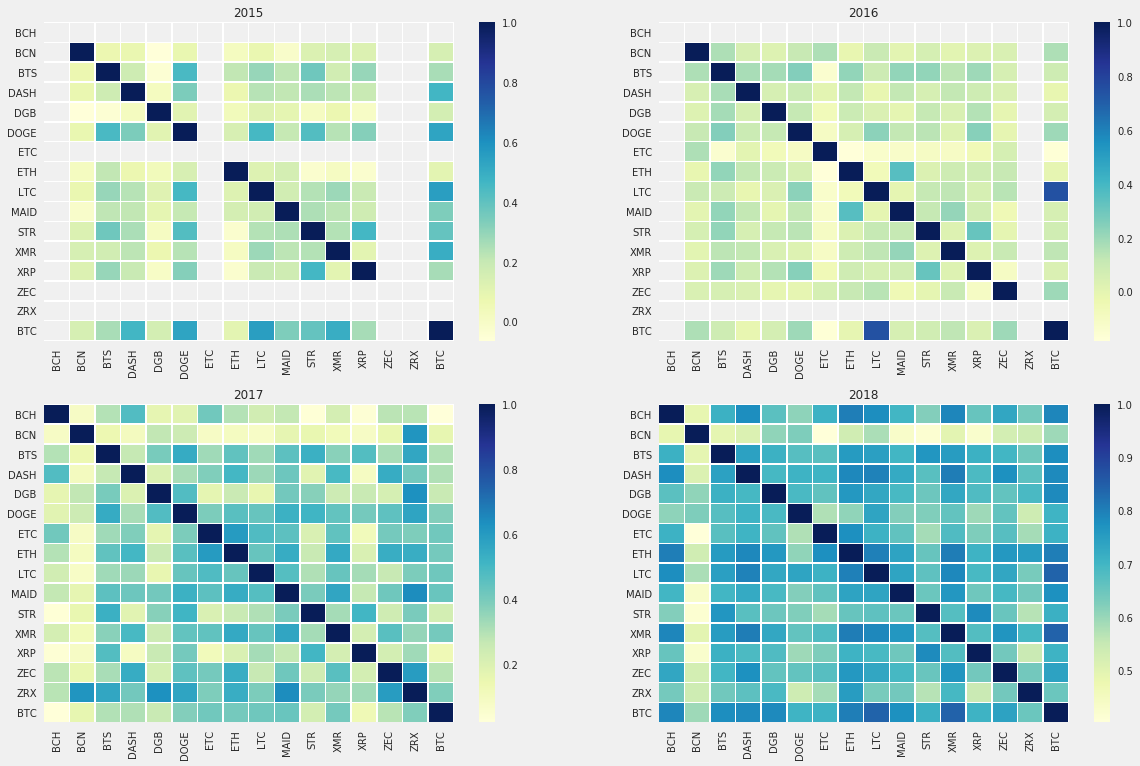

In [100]:
plt.style.use('fivethirtyeight')
plt.style.use('seaborn-notebook')

f,ax = plt.subplots(2, 2,figsize=(18, 12))

sns.heatmap(combined_df2015.pct_change().corr(), annot=False, linewidths=.5, fmt= '.2f',ax=ax[0,0],cmap="YlGnBu")

sns.heatmap(combined_df2016.pct_change().corr(), annot=False, linewidths=.5, fmt= '.2f',ax=ax[0,1],cmap="YlGnBu")

sns.heatmap(combined_df2017.pct_change().corr(), annot=False, linewidths=.5, fmt= '.2f',ax=ax[1,0],cmap="YlGnBu")

sns.heatmap(combined_df2018.pct_change().corr(), annot=False, linewidths=.5, fmt= '.2f',ax=ax[1,1],cmap="YlGnBu")

ax[0,0].set_title('2015')
ax[0,1].set_title('2016')
ax[1,0].set_title('2017')
ax[1,1].set_title('2018')

plt.show()

There was little statistically significant linkage between how the prices of different cryptocurrencies fluctuated during 2015 and 2016. In 2017's correlation heatmap, it is notable, that almost all of the cryptocurrencies have become more correlated with each other across the board. In 2018 we can observe too high correlation values between cryptos! 

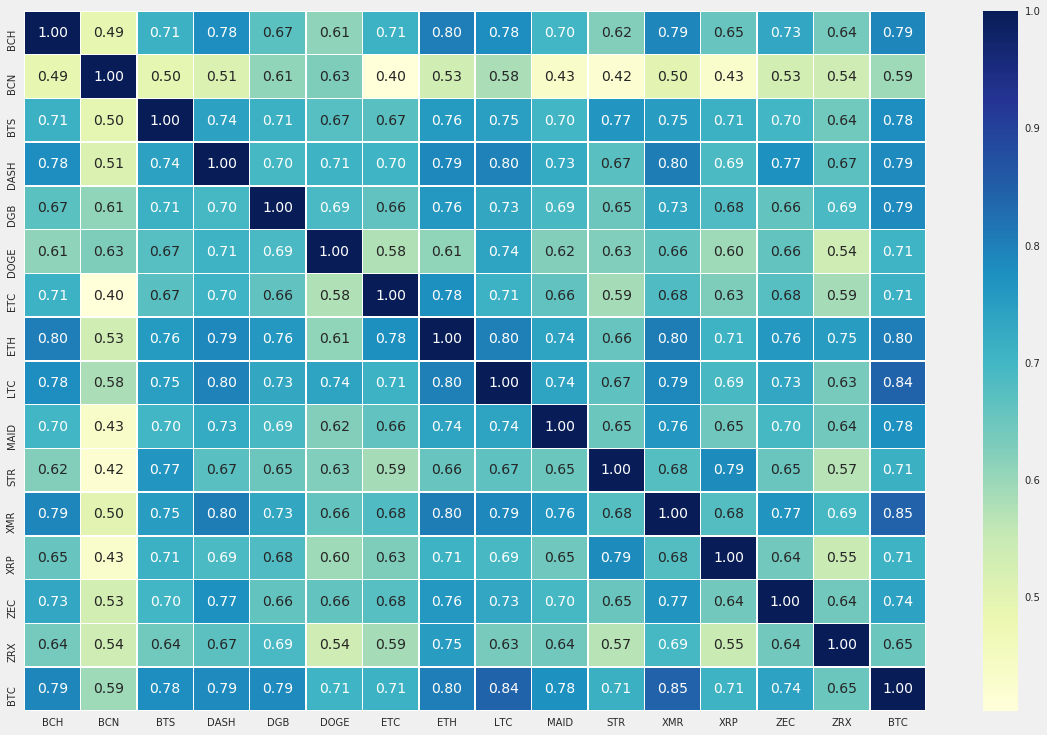

In [101]:
f,ax = plt.subplots(figsize=(18, 12))
sns.heatmap(combined_df2018.pct_change().corr(), annot=True, linewidths=.5, fmt= '.2f',ax=ax,cmap="YlGnBu")
plt.show()

**Lets concentrate on 2017 and 2018**

In [102]:
combined_df2017.describe()

BCH         BCN         BTS         DASH         DGB  \
count   140.000000  365.000000  365.000000   365.000000  365.000000   
mean    955.258474    0.001369    0.103049   243.495631    0.012096   
std     739.371163    0.001395    0.121931   261.903952    0.013982   
min     296.961444    0.000037    0.003122    11.444337    0.000211   
25%     424.533692    0.000133    0.008322    72.795058    0.000413   
50%     607.785118    0.001284    0.069865   176.929427    0.010178   
75%    1397.011469    0.001749    0.140408   306.942733    0.016143   
max    3458.666271    0.008109    0.610792  1402.425173    0.076897   

             DOGE         ETC         ETH         LTC        MAID         STR  \
count  365.000000  365.000000  365.000000  365.000000  365.000000  365.000000   
mean     0.001539   11.629565  220.030904   49.172918    0.360477    0.033206   
std      0.001578    8.707851  182.025358   62.594287    0.177373    0.054077   
min      0.000191    1.172033    8.222735    3.708275    0.085033    0.001674   
25%      0.000375    2.599654   45.989201    7.956422    0.196380    0.002770   
50%      0.001135   12.056308  240.403918   41.506998    0.362436    0.018512   
75%      0.001981   16.862359  309.144806   55.243562    0.472981    0.035574   
max      0.009787   39.012279  811.639229  346.905402    0.912347    0.329742   

              XMR         XRP         ZEC         ZRX           BTC  
count  365.000000  365.000000  365.000000  135.000000    365.000000  
mean    74.276636    0.193588  191.383123    0.276784   3955.082957  
std     82.398816    0.240716  129.477992    0.133634   3954.474198  
min     10.440639    0.005442   28.347167    0.166382    788.500156  
25%     20.301027    0.028987   63.747504    0.195905   1193.848961  
50%     44.343080    0.189258  208.663758    0.217095   2562.354396  
75%     93.273287    0.241064  269.082669    0.304942   4507.675004  
max    425.913240    2.077725  664.679719    0.796063  19237.154813

All cryptocurrencies above fluctuated a lot as you can observe in the table.

For each coin, we count the number of events and calculate mean, standard deviation, minimum, quartiles and maximum weighted price.

**Boxplots**

The following boxplots show information on the price distribution in 2017 and 2018 for ZRX and BCN cryptocurrencies respectively.

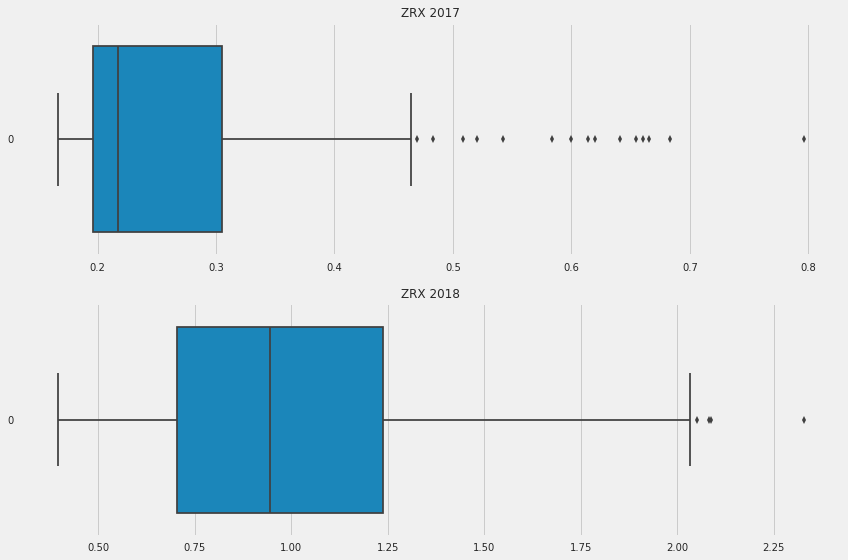

In [103]:
fig, axs = plt.subplots(nrows=2,figsize=(12, 8))
sns.boxplot(data=combined_df2017['ZRX'], ax=axs[0],orient="h").set_title('ZRX 2017')
sns.boxplot(data=combined_df2018['ZRX'], ax=axs[1],orient="h").set_title('ZRX 2018')
fig.tight_layout()
plt.show()


On the boxplots above:

    -We can see that ZRX price was most of the time between $0.2 and $0.3 approximately in the last year. All values over $0.46 are outliers, using the interquartile range (IQR) method.
      
    -In boxplot of 2018, we can observe that ZRX price was most of the time between $0.77 and $1.26 approximately in the last year. All values over $1.95 are outliers (using IQR).

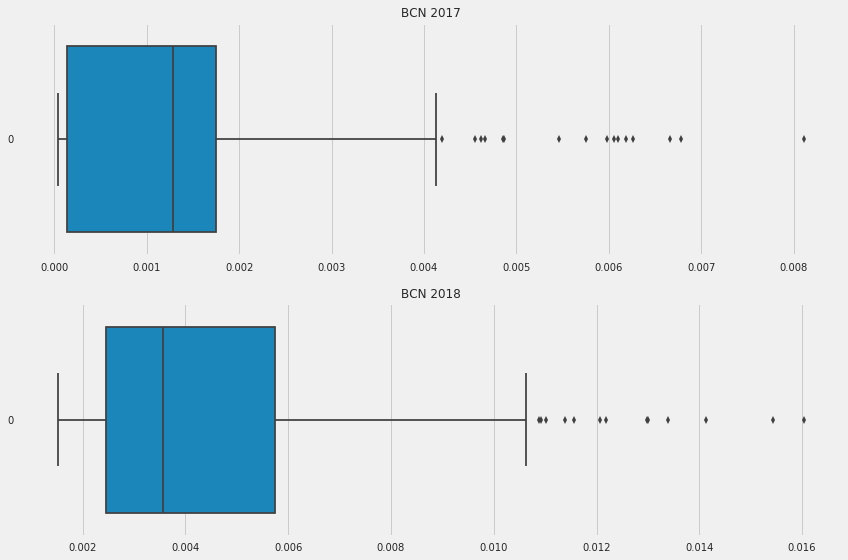

In [104]:
fig, axs = plt.subplots(nrows=2,figsize=(12, 8))
sns.boxplot(data=combined_df2017['BCN'], ax=axs[0],orient="h").set_title('BCN 2017')
sns.boxplot(data=combined_df2018['BCN'], ax=axs[1],orient="h").set_title('BCN 2018')
fig.tight_layout()
plt.show()


On the boxplots above:

    -We can see that BCN price was most of the time between $0.0 and $0.0017 approximately in the last year. All values over $0.0042 are outliers (using IQR).
    
    -In boxplot of 2018, we can observe that BCN price was most of the time between $0.003 and $0.006 approximately in the last year. All values over $0.011 are outliers (using IQR).

**Histograms**

The following histograms provide information on the price distribution in 2017 and 2018 for ZRX and BCN cryptocurrencies respectively.


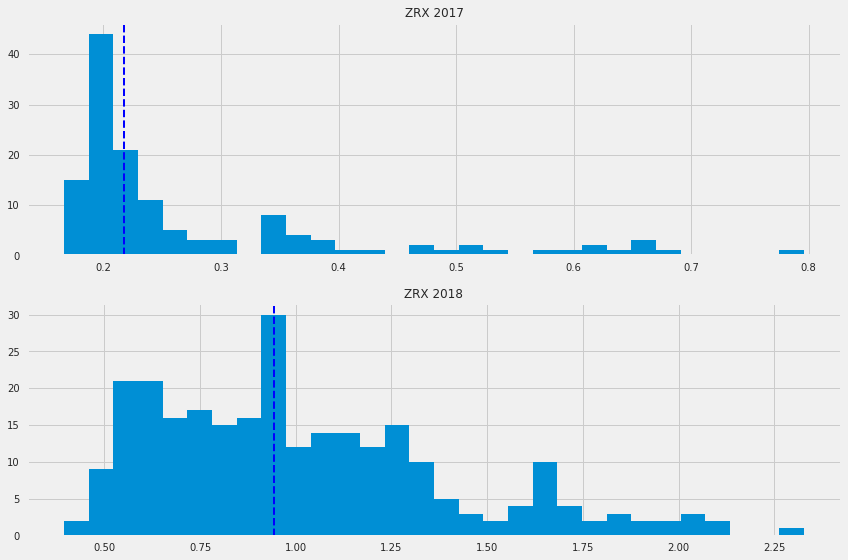

In [105]:
fig, axs = plt.subplots(nrows=2,figsize=(12, 8))

combined_df2017['ZRX'].hist(bins=30,ax=axs[0], figsize=(12,8)).axvline(combined_df2017['ZRX'].median(), color='b', linestyle='dashed', linewidth=2)
axs[0].set_title('ZRX 2017')

combined_df2018['ZRX'].hist(bins=30,ax=axs[1], figsize=(12,8)).axvline(combined_df2018['ZRX'].median(), color='b', linestyle='dashed', linewidth=2)
axs[1].set_title('ZRX 2018')

fig.tight_layout()
plt.show()

**Observations** :

1. For the graph about 2017 we can say that :

        -It shows the number of days ZRX had a certain value. For example, we can observe that ZRX price was not over $0.35 for many days.

        -It has right-skewed distribution because a natural limit prevents outcomes on one side.

        -Blue dotted line (median) shows that half of the prices were under $0.21.


2. For the graph about 2018 we can say that :

        -It shows the number of days ZRX had a certain value. For example, we can observe that ZRX price was not over $1.65 for many days.

        -It has approximately normal distribution with some right skewness.

        -Blue dotted line (median) shows that half of the prices were under $1.00.

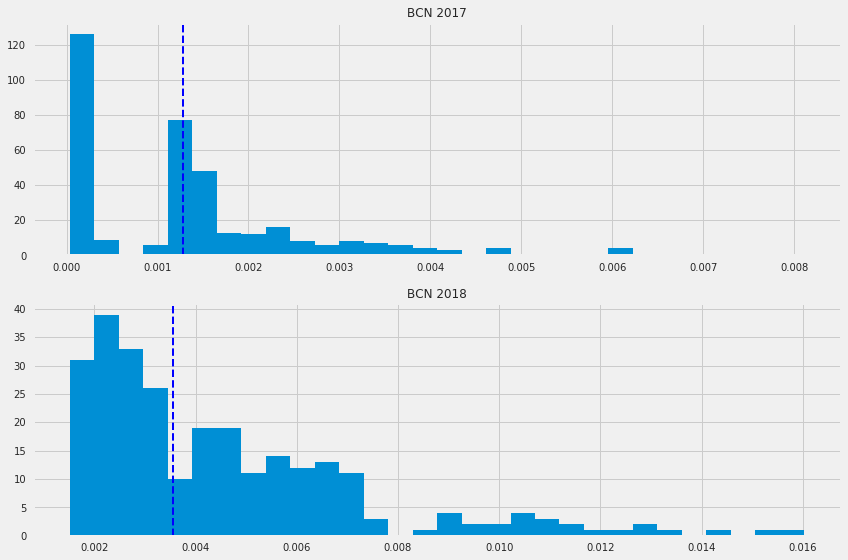

In [106]:
fig, axs = plt.subplots(nrows=2,figsize=(12, 8))

combined_df2017['BCN'].hist(bins=30,ax=axs[0], figsize=(12,8)).axvline(combined_df2017['BCN'].median(), color='b', linestyle='dashed', linewidth=2)
axs[0].set_title('BCN 2017')

combined_df2018['BCN'].hist(bins=30,ax=axs[1], figsize=(12,8)).axvline(combined_df2018['BCN'].median(), color='b', linestyle='dashed', linewidth=2)
axs[1].set_title('BCN 2018')

fig.tight_layout()
plt.show()

**Observations** :

1. For the graph about 2017 we can say that :

        -It shows the number of days BCN had a certain value. For example, we can observe that BCN price was not over $0.002 for many days.

        -It has right-skewed distribution because a natural limit prevents outcomes on one side.

        -Blue dotted line (median) shows that half of the prices were under $0.0012.

2. For the graph about 2018 we can say that :

       -It shows the number of days BCN had a certain value. For example, we can observe that BCN price was not over $0.007 for many days.
        
       -It has approximately normal distribution with some right skewness.
       
       -Blue dotted line (median) shows that half of the prices were under $0.004.

## Trading Strategies

A trading strategy is a set of objective rules defining the conditions that must be met for a trade entry and exit to occur.


### Buy And Hold

Buy and hold is a passive investment strategy in which an investor buys stocks and holds them for a long period of time, regardless of fluctuations in the market. An investor who employs a buy-and-hold strategy actively selects stocks, but once in a position, is not concerned with short-term price movements and technical indicators.

Let's analyze returns using buy and hold strategy for past year. 
We calculate the return percentage, where $t$ represents a certain time period and $price_0$ is initial price:

$$return_{t,0}=\frac{price_t}{price_0}$$


In [107]:
combined = combined_df2017.append(combined_df2018)
combined = combined.dropna()
combined.tail()

BCH       BCN       BTS        DASH       DGB      DOGE  \
date                                                                         
2018-09-20  438.995786  0.001859  0.118532  192.499587  0.024873  0.005705   
2018-09-21  481.474086  0.002002  0.124627  206.780060  0.025419  0.005671   
2018-09-22  483.166972  0.002009  0.122659  204.395144  0.025442  0.005691   
2018-09-23  489.320827  0.002012  0.124764  206.182692  0.025624  0.005836   
2018-09-24  471.177257  0.002254  0.118550  198.480038  0.025261  0.005768   

                  ETC         ETH        LTC      MAID       STR         XMR  \
date                                                                           
2018-09-20  10.815977  213.704082  54.773386  0.249821  0.223602  112.183391   
2018-09-21  11.394941  235.023861  58.929980  0.266268  0.252324  120.096916   
2018-09-22  11.424664  241.177347  59.960139  0.265470  0.239225  121.757680   
2018-09-23  11.557182  242.491530  61.736168  0.251876  0.279847  124.439861   
2018-09-24  11.200876  233.145102  58.597021  0.247243  0.264946  117.431671   

                 XRP         ZEC       ZRX          BTC  
date                                                     
2018-09-20  0.406625  116.200342  0.546056  6410.607686  
2018-09-21  0.556354  122.922317  0.617200  6671.706206  
2018-09-22  0.556785  122.999064  0.611151  6695.342377  
2018-09-23  0.575122  130.604818  0.639248  6707.748020  
2018-09-24  0.524257  138.574795  0.674831  6630.287311

In [108]:

df_return = combined.apply(lambda x: x / x[0])
df_return = df_return.dropna()
df_return.head()


BCH       BCN       BTS      DASH       DGB      DOGE  \
date                                                                     
2017-08-19  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
2017-08-20  0.974312  1.041646  1.051787  1.062624  1.189661  1.004445   
2017-08-21  0.821018  1.059553  1.027449  1.006173  1.206865  1.011143   
2017-08-22  0.860816  1.028410  1.044587  1.003177  1.113671  1.005360   
2017-08-23  0.860227  1.170744  1.182681  1.038168  1.149852  1.045172   

                 ETC       ETH       LTC      MAID       STR       XMR  \
date                                                                     
2017-08-19  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
2017-08-20  1.007919  1.006852  1.018285  1.066106  1.088360  1.025655   
2017-08-21  1.049066  1.112227  1.043517  1.105013  1.138823  1.483029   
2017-08-22  1.037972  1.074290  1.028935  1.061424  1.187767  1.628155   
2017-08-23  1.144891  1.098399  1.165304  1.086094  1.401738  1.756977   

                 XRP       ZEC       ZRX       BTC  
date                                                
2017-08-19  1.000000  1.000000  1.000000  1.000000  
2017-08-20  1.017489  1.079944  0.849797  1.004445  
2017-08-21  1.139434  1.115774  0.739248  0.986481  
2017-08-22  1.382555  1.029213  0.687974  0.957485  
2017-08-23  1.751807  1.053592  0.782352  1.019680

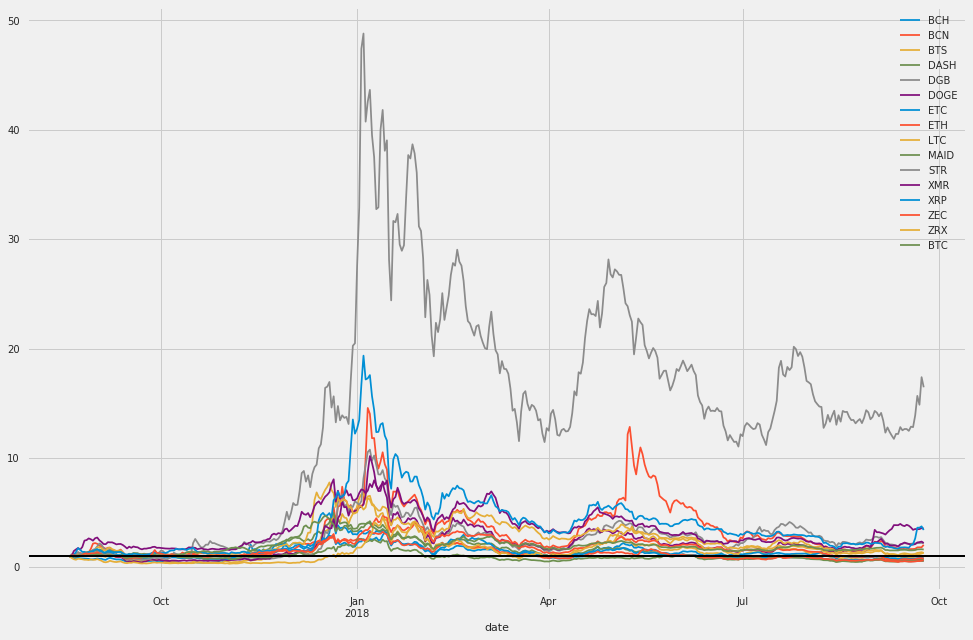

In [109]:
df_return.plot(grid=True, figsize=(15, 10)).axhline(y = 1, color = "black", lw = 2)

plt.show()


**Lets focus on ZRX and BCN cryptos.**

In [110]:

return_trace1 = go.Scatter(x=df_return.index, 
                           y=df_return['ZRX'],
                           name = "ZRX Return",
                           line = dict(color = 'green'),
                           opacity = 0.8)
return_trace2 = go.Scatter(x=df_return.index, 
                           y=df_return['BCN'],
                           name = "BCN Return",
                           line = dict(color = 'red'),
                           opacity = 0.8)


data = [return_trace1,return_trace2]

layout = dict(
    title='Returns (Buy & Hold Strategy)',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(),
        type='date'
    )
)

fig = dict(data=data, layout=layout)
py.iplot(fig, filename = "Time Series with Rangeslider")

**What is the percentage increase?**


In [111]:
df_return.head()

BCH       BCN       BTS      DASH       DGB      DOGE  \
date                                                                     
2017-08-19  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
2017-08-20  0.974312  1.041646  1.051787  1.062624  1.189661  1.004445   
2017-08-21  0.821018  1.059553  1.027449  1.006173  1.206865  1.011143   
2017-08-22  0.860816  1.028410  1.044587  1.003177  1.113671  1.005360   
2017-08-23  0.860227  1.170744  1.182681  1.038168  1.149852  1.045172   

                 ETC       ETH       LTC      MAID       STR       XMR  \
date                                                                     
2017-08-19  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000   
2017-08-20  1.007919  1.006852  1.018285  1.066106  1.088360  1.025655   
2017-08-21  1.049066  1.112227  1.043517  1.105013  1.138823  1.483029   
2017-08-22  1.037972  1.074290  1.028935  1.061424  1.187767  1.628155   
2017-08-23  1.144891  1.098399  1.165304  1.086094  1.401738  1.756977   

                 XRP       ZEC       ZRX       BTC  
date                                                
2017-08-19  1.000000  1.000000  1.000000  1.000000  
2017-08-20  1.017489  1.079944  0.849797  1.004445  
2017-08-21  1.139434  1.115774  0.739248  0.986481  
2017-08-22  1.382555  1.029213  0.687974  0.957485  
2017-08-23  1.751807  1.053592  0.782352  1.019680

In [112]:
df_return.tail()

BCH       BCN       BTS      DASH       DGB      DOGE  \
date                                                                     
2018-09-20  0.561597  1.689557  0.958649  0.681427  2.164318  3.500004   
2018-09-21  0.615939  1.819004  1.007947  0.731978  2.211832  3.478846   
2018-09-22  0.618105  1.825449  0.992024  0.723536  2.213842  3.491170   
2018-09-23  0.625977  1.828831  1.009052  0.729864  2.229617  3.579936   
2018-09-24  0.602766  2.048740  0.958790  0.702597  2.198100  3.538595   

                 ETC       ETH       LTC      MAID        STR       XMR  \
date                                                                      
2018-09-20  0.798948  0.734199  1.225112  0.573659  13.890500  2.119591   
2018-09-21  0.841715  0.807445  1.318082  0.611424  15.674751  2.269109   
2018-09-22  0.843910  0.828586  1.341124  0.609593  14.861000  2.300487   
2018-09-23  0.853699  0.833101  1.380848  0.578377  17.384542  2.351164   
2018-09-24  0.827379  0.800991  1.310635  0.567739  16.458871  2.218752   

                 XRP       ZEC       ZRX       BTC  
date                                                
2018-09-20  2.644517  0.532187  1.073905  1.573035  
2018-09-21  3.618290  0.562973  1.213821  1.637104  
2018-09-22  3.621094  0.563324  1.201926  1.642904  
2018-09-23  3.740354  0.598158  1.257184  1.645948  
2018-09-24  3.409546  0.634660  1.327162  1.626940

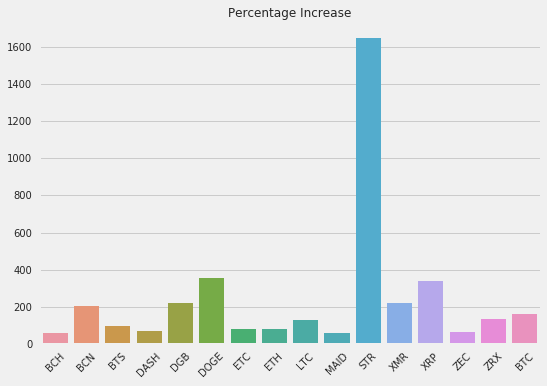

In [113]:
df_perc = df_return.tail(1) * 100
ax = sns.barplot(data=df_perc)

for item in ax.get_xticklabels():
    item.set_rotation(45)

ax.set_title('Percentage Increase')
plt.show()

**What if we invest 1000 dollars in 19/08/2017 ?**

In [114]:
combined.head(1)

BCH     BCN       BTS       DASH       DGB     DOGE  \
date                                                                     
2017-08-19  781.691231  0.0011  0.123645  282.49485  0.011492  0.00163   

                  ETC         ETH        LTC      MAID       STR        XMR  \
date                                                                          
2017-08-19  13.537773  291.070974  44.708885  0.435488  0.016097  52.926912   

                 XRP         ZEC       ZRX          BTC  
date                                                     
2017-08-19  0.153761  218.345022  0.508476  4075.310363

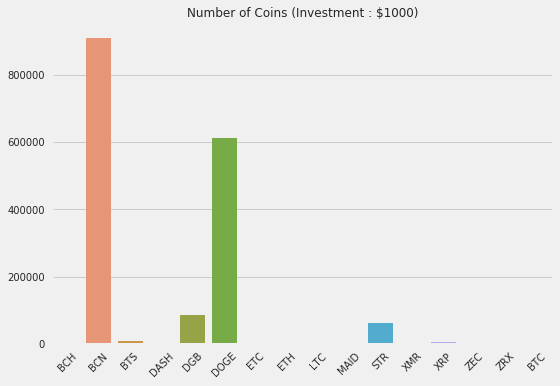

In [115]:
budget = 1000 # USD
df_coins = budget/combined.head(1)

ax = sns.barplot(data=df_coins)

for item in ax.get_xticklabels():
    item.set_rotation(45)

ax.set_title('Number of Coins (Investment : $1000)')
plt.show()

In [116]:
combined.tail()

BCH       BCN       BTS        DASH       DGB      DOGE  \
date                                                                         
2018-09-20  438.995786  0.001859  0.118532  192.499587  0.024873  0.005705   
2018-09-21  481.474086  0.002002  0.124627  206.780060  0.025419  0.005671   
2018-09-22  483.166972  0.002009  0.122659  204.395144  0.025442  0.005691   
2018-09-23  489.320827  0.002012  0.124764  206.182692  0.025624  0.005836   
2018-09-24  471.177257  0.002254  0.118550  198.480038  0.025261  0.005768   

                  ETC         ETH        LTC      MAID       STR         XMR  \
date                                                                           
2018-09-20  10.815977  213.704082  54.773386  0.249821  0.223602  112.183391   
2018-09-21  11.394941  235.023861  58.929980  0.266268  0.252324  120.096916   
2018-09-22  11.424664  241.177347  59.960139  0.265470  0.239225  121.757680   
2018-09-23  11.557182  242.491530  61.736168  0.251876  0.279847  124.439861   
2018-09-24  11.200876  233.145102  58.597021  0.247243  0.264946  117.431671   

                 XRP         ZEC       ZRX          BTC  
date                                                     
2018-09-20  0.406625  116.200342  0.546056  6410.607686  
2018-09-21  0.556354  122.922317  0.617200  6671.706206  
2018-09-22  0.556785  122.999064  0.611151  6695.342377  
2018-09-23  0.575122  130.604818  0.639248  6707.748020  
2018-09-24  0.524257  138.574795  0.674831  6630.287311

**Our profit months later will be : **

In [117]:
df_return.tail(1)

BCH      BCN      BTS      DASH     DGB      DOGE       ETC  \
date                                                                           
2018-09-24  0.602766  2.04874  0.95879  0.702597  2.1981  3.538595  0.827379   

                 ETH       LTC      MAID        STR       XMR       XRP  \
date                                                                      
2018-09-24  0.800991  1.310635  0.567739  16.458871  2.218752  3.409546   

                ZEC       ZRX      BTC  
date                                    
2018-09-24  0.63466  1.327162  1.62694

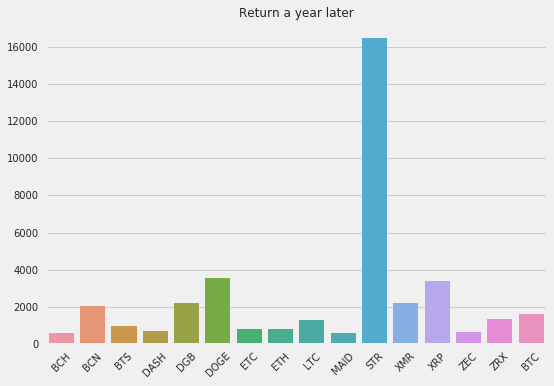

In [118]:
df_profit = df_return.tail(1) * budget

ax = sns.barplot(data=df_profit)

for item in ax.get_xticklabels():
    item.set_rotation(45)

ax.set_title('Return a year later')
plt.show()

In [119]:
df_profit

BCH          BCN         BTS        DASH          DGB  \
date                                                                       
2018-09-24  602.766461  2048.739837  958.790224  702.597013  2198.100407   

                   DOGE         ETC         ETH          LTC        MAID  \
date                                                                       
2018-09-24  3538.595497  827.379471  800.990561  1310.634797  567.739189   

                     STR          XMR          XRP         ZEC          ZRX  \
date                                                                          
2018-09-24  16458.871069  2218.751621  3409.546304  634.659739  1327.161977   

                    BTC  
date                     
2018-09-24  1626.940459

### Log Returns

We analyzed raw price changes of cryptocurrencies. The problem with that approach is that prices of different cryptocurrencies are not normalized and we cannot use comparable metrics.

Benefit of using returns, versus prices, is normalization: measuring all variables in a comparable metric, thus enabling evaluation of analytic relationships amongst two or more variables despite originating from price series of unequal values
Let's define return as:

>>>$$r_{i} = \frac{p_i - p_j}{p_j},$$
where $r_i$ is return at time $i$, $p_i$ is the price at time $i$ and $j = i-1$.

#### Calculate Log Returns

We transform **returns** equation to **log returns** equation:

>>>$$r_{i} = \frac{p_i - p_j}{p_j}$$

>>>$$r_i = \frac{p_i}{p_j} - \frac{p_j}{p_j}$$

>>>$$1 + r_i = \frac{p_i}{p_j}$$


>>>$$log(1+r_i) = log(\frac{p_i}{p_j})$$

>>>$$log(1+r_i) = log(p_i) - log(p_j)$$

Now, we apply the log returns equation to closing prices of cryptocurrencies:

In [120]:
df_change = combined_df2018.apply(lambda x: np.log(x) - np.log(x.shift(1)))
df_change = df_change.dropna()
df_change.head()


BCH       BCN       BTS      DASH       DGB      DOGE  \
date                                                                     
2018-01-02  0.084405  0.049398  0.124927  0.091527 -0.031308  0.049398   
2018-01-03  0.021941 -0.010238  0.054208  0.014810  0.058222  0.011589   
2018-01-04 -0.078390  0.037179  0.005268  0.001535  0.295956  0.038342   
2018-01-05 -0.003485  0.544467 -0.079041 -0.005003  0.134707  0.133119   
2018-01-06  0.036604  0.375265  0.044606  0.012759  0.123917  0.282982   

                 ETC       ETH       LTC      MAID       STR       XMR  \
date                                                                     
2018-01-02  0.078073  0.134696  0.103314  0.029382  0.178251  0.073173   
2018-01-03 -0.001991  0.048954 -0.002737  0.000597  0.365129  0.048467   
2018-01-04  0.084854  0.058012 -0.053956 -0.032687  0.029097 -0.009974   
2018-01-05 -0.032211  0.038018  0.037360 -0.097947 -0.180510 -0.040260   
2018-01-06 -0.020848 -0.000248  0.145571  0.041325  0.044049  0.035506   

                 XRP       ZEC       ZRX       BTC  
date                                                
2018-01-02  0.060377  0.073443 -0.006269  0.049398  
2018-01-03  0.213935 -0.000066  0.019047  0.060380  
2018-01-04  0.148232 -0.025510  0.123143 -0.010449  
2018-01-05 -0.119599 -0.002684  0.112988  0.071561  
2018-01-06  0.006376  0.112403  0.062380  0.045023

We plot normalized changes of closing prices for last 30 days of year 2017. Log differences can be interpreted as the percentage change.


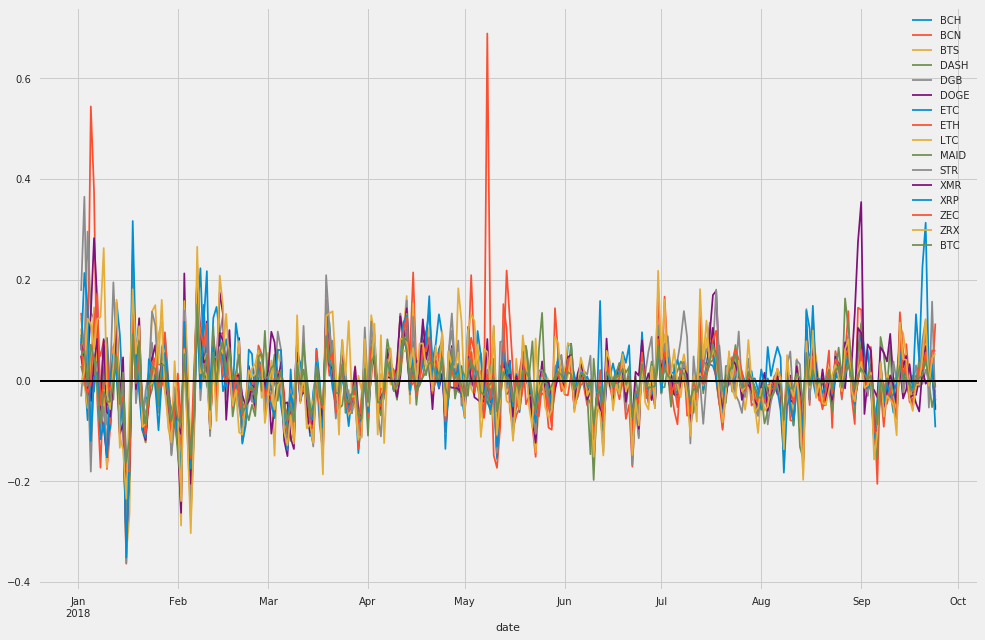

In [121]:

df_change.plot(figsize=(15, 10)).axhline(color='black', linewidth=2)
plt.show()

**Lets focus on ZRX, BCN cryptos.**

In [122]:

return_trace1 = go.Scatter(x=df_change.index, 
                           y=df_change['ZRX'],
                           name = "ZRX Return",
                           line = dict(color = 'green'),
                           opacity = 0.8)
return_trace2 = go.Scatter(x=df_change.index, 
                           y=df_change['BCN'],
                           name = "BCN Return",
                           line = dict(color = 'red'),
                           opacity = 0.8)

data = [return_trace1,return_trace2]


layout = dict(
    title='Log Returns',
    xaxis=dict(
        rangeselector=dict(
            buttons=list([
                dict(count=1,
                     label='1m',
                     step='month',
                     stepmode='backward'),
                dict(count=6,
                     label='6m',
                     step='month',
                     stepmode='backward'),
                dict(step='all')
            ])
        ),
        rangeslider=dict(),
        type='date'
    )
)

fig = dict(data=data, layout=layout)
py.iplot(fig, filename = "Time Series with Rangeslider")

**Checking for normality in ZRX, BCN log returns**

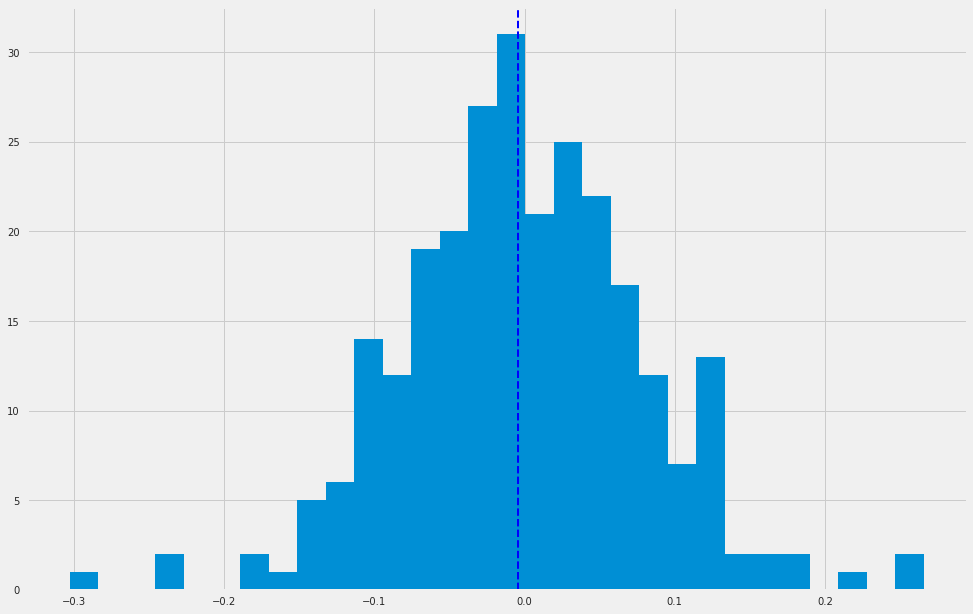

In [123]:
df_change['ZRX'].hist(bins=30, figsize=(15,10)).axvline(df_change['ZRX'].median(), color='b', linestyle='dashed', linewidth=2)
plt.show()

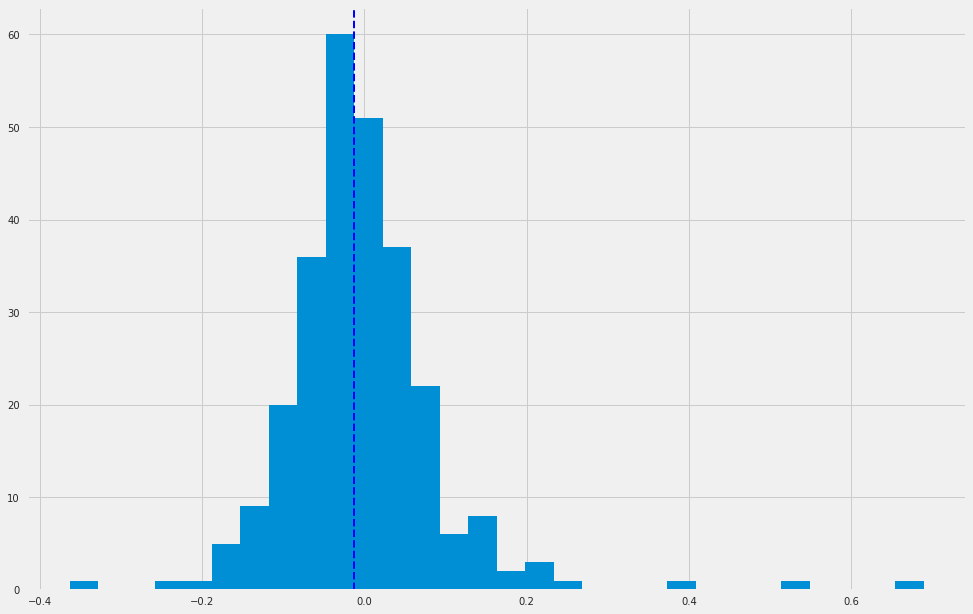

In [124]:
df_change['BCN'].hist(bins=30, figsize=(15,10)).axvline(df_change['BCN'].median(), color='b', linestyle='dashed', linewidth=2)
plt.show()

ZRX and BCN log returns are approximately normal.

We observe an expected behaviour. Log return and Gross return(pct_change()) are very close when your gross return is small, say less than 1%. It can be mathematically proved by 2nd-order Taylor expansion around 0.